In [146]:
import lightgbm as lgb
from sklearn.model_selection import RepeatedStratifiedKFold
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import seaborn as sns
import numpy as np

from sklearn import metrics
from sklearn.preprocessing import StandardScaler

from load_data import AMLData, cluster_colors, load_table

In [147]:
# point of access for all data
data = AMLData()

significant not in columns.
p_value not in columns.


In [148]:
# only use the 159 patients that rna exists
rna = data.rna
rna_patients = rna['sample_id'].unique()

In [149]:
cluster_labels = data.meta['Cluster']

In [150]:
cluster_labels.loc[rna_patients]

sample_id
12-00294    2
13-00016    2
13-00034    4
13-00123    4
13-00147    3
           ..
18-00408    1
18-00414    2
19-00084    2
19-00092    2
19-00154    4
Name: Cluster, Length: 159, dtype: int64

In [151]:
prot = data.subset(['proteomics',  'phospho'])

In [152]:
prot.shape

(210, 21169)

In [153]:
outside_nmf = prot.loc[~prot.sample_id.isin(rna_patients)]
outside_nmf.shape

(51, 21169)

In [154]:
prot_used_in_nmf = prot.loc[prot.sample_id.isin(rna_patients)]

prot_used_in_nmf.shape
prot_used_in_nmf= prot_used_in_nmf.set_index('sample_id')

In [155]:
protein_features = prot_used_in_nmf.columns
joined = prot_used_in_nmf.join(cluster_labels)
joined.shape

(159, 21169)

In [156]:
def plot_all_features(features, yticklabels=False):
    
    test = data.exp_data.species.subset(
        features,
        index='label'
    )

    prot = test.pivoter(
        index='label',
        values='exp_value',
        columns='sample_id'
    )

    # create cluster labels for top
    node_labels = cluster_labels.copy()
    node_lut = dict(zip(sorted(node_labels.unique()), cluster_colors))
    node_colors = pd.Series(node_labels, index=data.meta.index.values, name='Cluster').map(node_lut)
    handles = [Patch(facecolor=node_lut[name]) for name in node_lut]


    in_all_nodes = set(prot.columns).intersection(node_colors.index)
    prot = prot[in_all_nodes]
    prot = prot[rna_patients]
    cmap = sns.color_palette("RdBu_r", 11)
    vmax = 2
    sns.clustermap(
        prot.fillna(0.01),
        mask=prot.isnull(),
        figsize=(12, 12),
        z_score=0,
        row_cluster=True,
        col_cluster=True,
        method='ward',
        metric='euclidean',
        col_colors= node_colors,
        vmax=vmax,
        vmin=-1*vmax,
        yticklabels=yticklabels,
        xticklabels=False,
        cmap=cmap
    #     linewidths=0.001

    )

    plt.legend(
        handles, node_lut, title='Cluster',
        bbox_to_anchor=(1.1, .8),
        bbox_transform=plt.gcf().transFigure,
        loc='upper right'
    )
    return prot

In [157]:
 param = dict(
    device_ype='cpu',
    boosting_type='rf',
    num_threads=8,
    n_jobs=None,
    objective='multiclass',
    num_class=4,
    metric='multi_logloss',
#      metric='auc_mu',
    lambda_l1=1,
    lambda_l2=1,
    reg_alpha=None,
    reg_lambda=None,
    learning_rate=.1,
#     tree_learner='serial',
#     max_bin=128,
    num_leaves=10,
    max_depth=-1,

    zero_as_missing=True,
    is_unbalance=False,

#     feature_fraction=.5, #.8

    subsample_freq=1,
    subsample=.8,
#     min_child_weight=0.02,
    min_data_in_leaf=5,
#     min_child_samples=None,
#     min_gain_to_split=None,
#     colsample_bytree=None,
#     min_split_gain=1,
    n_estimators=10000,
    verbose=-1,
#     verbose=1,
    deterministic=True,
    random_state=10,
    force_col_wise=True

)
    
def run_gbt(x_train, y_train, x_test, y_test, feature_names):
    
    eval_metric = 'multi_logloss'

    lgb_model = lgb.LGBMClassifier(**param)
    lgb_model.fit(
        x_train, y_train,
        callbacks=[lgb.early_stopping(
            1000, first_metric_only=True, verbose=False)
        ],
        eval_metric=eval_metric,
        eval_set=[(x_train, y_train), (x_test, y_test)],
    )

    feats = pd.Series(lgb_model.feature_importances_, index=feature_names)
    print(feats.sort_values(ascending=False))
    selected_feat = feats[feats > 0].index.values

    preds = lgb_model.predict(x_test, num_iteration=lgb_model.best_iteration_)
    
    avg_prec = metrics.accuracy_score(y_test, preds)
    
#     preds = np.where((preds > 0.5), 1, 0)
    prec = metrics.precision_score(y_test, preds, zero_division=1, average='macro')
    f1 = metrics.f1_score(y_test, preds, zero_division=1, average='macro')
    recall = metrics.recall_score(y_test, preds, average='macro')
    return {
        'avg_prec': avg_prec,
        
        'prec': prec,
        'recall': recall,
        'f1': f1,
        'feature_names': sorted(selected_feat),
        'n_feat': len(selected_feat),
    }

def run_model():

    features, target = joined[protein_features].copy(), joined['Cluster'].copy()
    features.replace(0, np.nan, inplace=True)
    features.dropna(
        axis=1,
        how='any',
        thresh=features.shape[0] * .5,
        inplace=True
    )
    feature_names = list(set(features.columns.values))

    all_results = []
    
    kf = RepeatedStratifiedKFold(
        n_splits=2,
        n_repeats=2,
        random_state=101
    )
    for n, (train_index, test_index) in enumerate(kf.split(features, target)):
        print(n)
        x_train, x_test = features.iloc[train_index], features.iloc[test_index]
        y_train, y_test = target[train_index], target[test_index]
        args = dict(
            x_train=x_train,
            y_train=y_train,
            x_test=x_test,
            y_test=y_test
        )
        gbt_binary_results = run_gbt(feature_names=feature_names,  **args)
        results = pd.DataFrame([gbt_binary_results])
        results['k'] = n
        all_results.append(results)
        break
        
    out_name = 'test'
    target_name = 'cluster'
    all_results = pd.concat(all_results)
    all_results['target_name'] = target_name
    all_results['data_type'] = out_name
    cols = ['model', 'n_feat', 'avg_prec']
#     print(d_sets, drug_name)
    with pd.option_context("display.precision", 2):
#         print(all_results[cols])
        print(all_results.mean().T)
    all_results.feature_names = all_results.feature_names.str.join('|')
    return all_results
df = run_model()

0
[LightGBM] [Warning] Unknown parameter: device_ype
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
THUMPD3_prot             240
SCNM1-S183s              127
DNMT1-S141s               96
CRYBG1-S818s              78
ESYT2-S755sS758sS761s     78
                        ... 
IL1RAP-S557s               0
ALDOA_prot                 0
KIAA1551-S1708s            0
PXN-S137s                  0
LILRA2_prot                0
Length: 21032, dtype: int32
avg_prec      0.74
prec          0.70
recall        0.68
f1            0.68
n_feat      654.00
k             0.00
dtype: float64


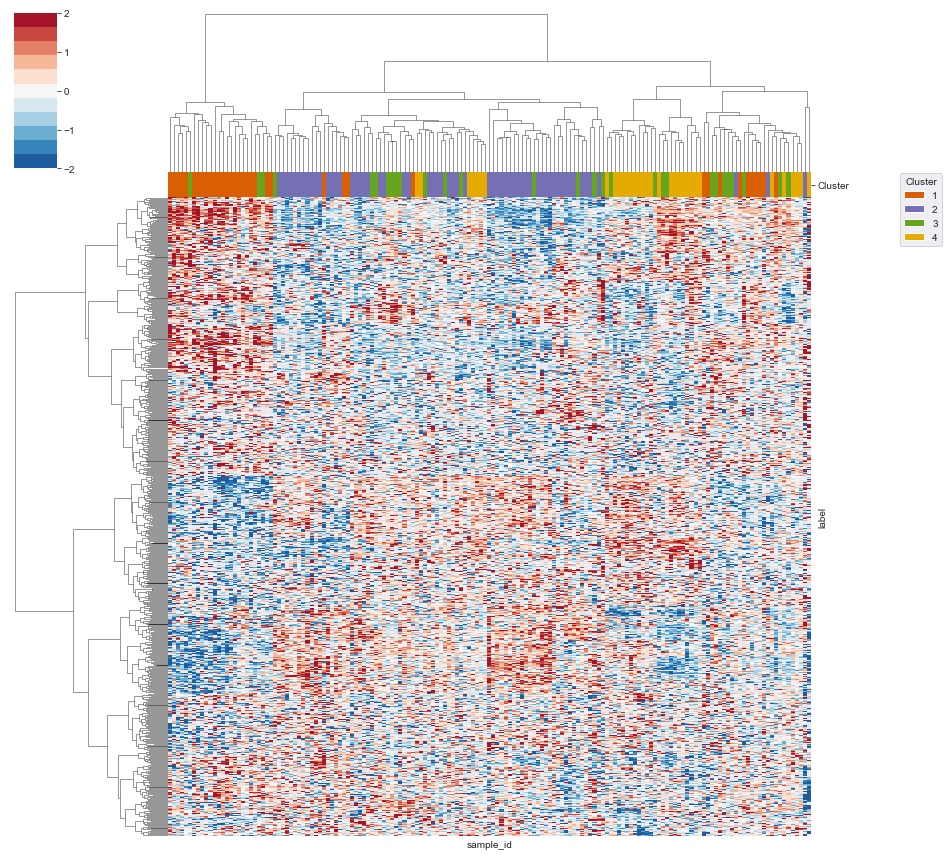

In [158]:
fets = df.feature_names.str.split('|')[0]
fets
plot_all_features(fets);


In [159]:
param = dict(
    device_type='cpu',
    boosting_type='rf',
    num_threads=8,
    n_jobs=None,
    objective='multiclass',
    num_class=4,
    metric='multi_logloss',
#      metric='auc_mu',
    lambda_l1=10,
    lambda_l2=1,
    reg_alpha=None,
    reg_lambda=None,
    learning_rate=.1,
#     tree_learner='serial',
#     max_bin=128,
    num_leaves=10,
    max_depth=-1,

    zero_as_missing=True,
    is_unbalance=False,

#     feature_fraction=.5, #.8

    subsample_freq=1,
    subsample=.8,
#     min_child_weight=0.02,
    min_data_in_leaf=5,
#     min_child_samples=None,
#     min_gain_to_split=None,
#     colsample_bytree=None,
#     min_split_gain=1,
    n_estimators=1000,
    verbose=-1,
#     verbose=1,
    deterministic=True,
    random_state=10,
    force_col_wise=True

)

features, target = joined[protein_features].copy(), joined['Cluster'].copy()
print(features.shape)
print(features.shape[0] * .5)
features.replace(0, np.nan, inplace=True)
features.dropna(
    axis=1,
    how='any',
    thresh=features.shape[0] * .5,
    inplace=True
)

features_scaled = StandardScaler().fit_transform(features)
print(features.shape)
features_scaled = pd.DataFrame(features_scaled, index=features.index, columns=features.columns)

(159, 21168)
79.5
(159, 21032)


In [160]:
lgb_model = lgb.LGBMClassifier(**param)
lgb_model.fit(features_scaled, target)

[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5


LGBMClassifier(boosting_type='rf', deterministic=True, device_type='cpu',
               force_col_wise=True, is_unbalance=False, lambda_l1=10,
               lambda_l2=1, metric='multi_logloss', min_data_in_leaf=5,
               n_estimators=1000, n_jobs=None, num_class=4, num_leaves=10,
               num_threads=8, objective='multiclass', random_state=10,
               reg_alpha=None, reg_lambda=None, subsample=0.8, subsample_freq=1,
               verbose=-1, zero_as_missing=True)

In [161]:
# lgb_model.save_model('lgb_classifier.txt', num_iteration=lgb_model.best_iteration) 


# lgb_model = lgb.Booster(model_file='lgb_classifier.txt')

In [162]:
feats = pd.Series(lgb_model.feature_importances_, index=features.columns.values)
feats = feats[feats > 100]

selected_feat = feats.index.values
print(feats.sort_values(ascending=False))


print(f"number of features = {len(selected_feat)}")
preds_original = lgb_model.predict(features_scaled, num_iteration=lgb_model.best_iteration_)

avg_prec = metrics.accuracy_score(target, preds_original)

# preds = np.where((preds_original > 0.5), 1, 0)
prec = metrics.precision_score(target, preds_original, zero_division=1, average='macro')
f1 = metrics.f1_score(target, preds_original, zero_division=1, average='macro')
recall = metrics.recall_score(target, preds_original, average='macro')
results_dict =  {
    'avg_prec': avg_prec,

    'prec': prec,
    'recall': recall,
    'f1': f1,
    'feature_names': sorted(selected_feat),
    'n_feat': len(selected_feat),
}

results = pd.DataFrame([results_dict])

CALCOCO2_prot    923
ARPC1B_prot      438
ARGLU1-S77s      376
TLR2_prot        372
LACTB_prot       354
ZBTB7B_prot      312
GYS1_prot        252
BTBD1_prot       185
EHBP1L1_prot     152
FGR_prot         150
COX7C_prot       146
SLPI_prot        126
CASP3-S26s       113
TRIM24_prot      113
RNF185_prot      111
FADS2_prot       109
ANKHD1_prot      106
TMX2_prot        105
RNF4_prot        104
EPB42_prot       103
PDCD2_prot       102
dtype: int32
number of features = 21


In [163]:
results

,avg_prec,prec,recall,f1,feature_names,n_feat
0,0.968553,0.977796,0.956897,0.965017,"[ANKHD1_prot, ARGLU1-S77s, ARPC1B_prot, BTBD1_...",21


In [164]:
print(metrics.classification_report(target, preds_original))

              precision    recall  f1-score   support

           1       0.97      1.00      0.99        37
           2       0.94      1.00      0.97        60
           3       1.00      0.83      0.91        29
           4       1.00      1.00      1.00        33

    accuracy                           0.97       159
   macro avg       0.98      0.96      0.97       159
weighted avg       0.97      0.97      0.97       159



21


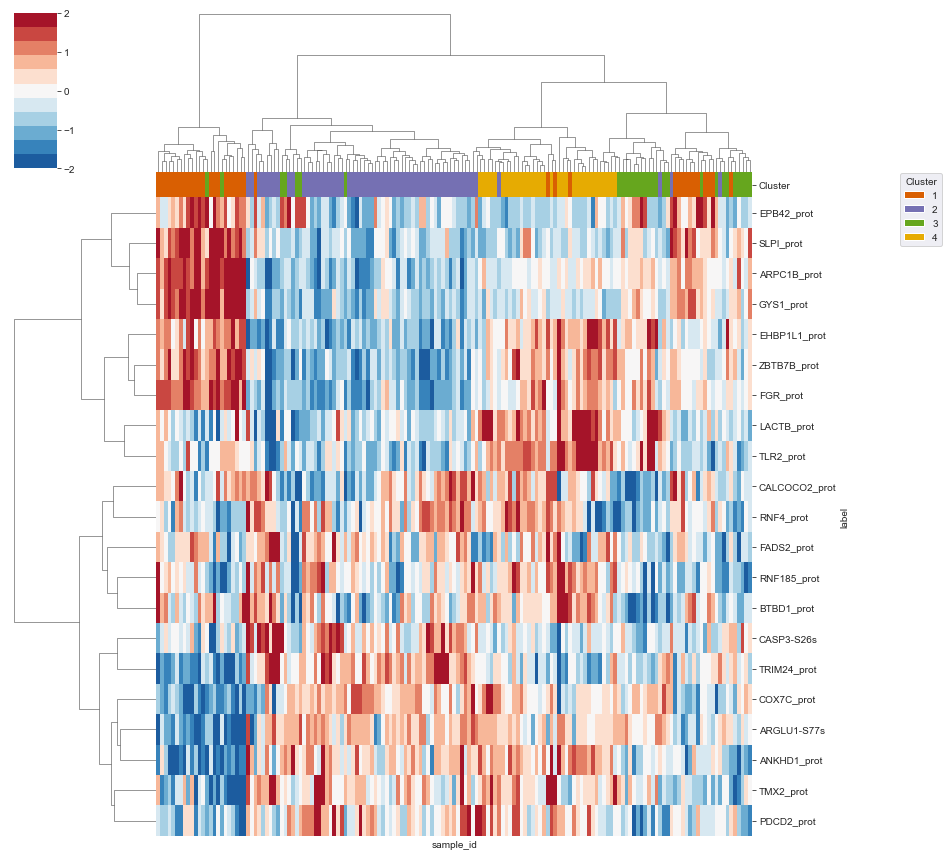

In [165]:
fets = results.feature_names[0]
print(len(fets))
plot_all_features(fets, yticklabels=True);

In [166]:
features_scaled

,A2M_prot,AAAS-S495s,AAAS-S541s,AAAS_prot,AACS_prot,AAGAB_prot,AAK1-S18s,AAK1-S20s,AAK1-S21s,AAK1-S637s,...,ZYX-Y172y,ZYX_prot,ZZEF1-S1464s,ZZEF1-S1518s,ZZEF1-S2526s,ZZEF1-T1512tS1518s,ZZEF1_prot,ZZZ3-S314s,ZZZ3_prot,hCG_2039718-S157s
sample_id,,,,,,,,,,,,,,,,,,,,,
12-00294,-0.494624,0.217156,NaN,-1.032936,-1.392707,-0.863684,-0.682685,-0.366550,-0.003262,0.114542,...,NaN,-0.037301,NaN,0.303804,1.390257,0.934918,-0.288922,-0.959748,-0.798505,0.389465
13-00016,-0.734994,0.037670,0.263070,-1.245638,-0.374473,-1.095161,0.341789,NaN,-0.426739,-0.390557,...,NaN,-0.772753,-0.539121,-0.145029,-0.561125,NaN,0.322422,-0.160671,0.056864,NaN
13-00034,0.856998,1.274628,1.188833,0.455981,1.466539,1.512810,-0.911772,0.595593,0.401588,1.209497,...,-0.839520,-0.621633,NaN,-0.528774,-0.315869,1.328987,-0.149423,1.504695,0.552176,-0.320960
13-00123,0.866243,0.189685,-0.475547,0.845936,1.957971,0.944406,2.124996,1.417198,0.089479,2.360436,...,2.983939,0.130237,1.067270,-0.361988,1.118344,-0.133716,-0.021190,0.364223,-0.145210,0.566821
13-00147,-0.098012,NaN,NaN,1.718902,-0.439625,0.173589,-0.688184,0.697521,-1.199581,-0.616992,...,NaN,-0.382826,-0.985716,0.585850,NaN,-0.332193,-0.090906,NaN,-2.397586,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18-00408,0.673947,NaN,NaN,-1.139287,0.777788,-0.902263,-0.911772,-0.554963,-0.765601,-1.824226,...,NaN,0.822405,0.429438,-4.668613,1.843447,NaN,2.277395,-0.333502,-1.273572,NaN
18-00414,-0.896782,NaN,NaN,-1.170306,-1.128375,-0.072548,0.116368,-1.148002,-1.659323,-1.442665,...,0.683499,-0.448125,-0.324261,0.051725,1.656840,1.418694,-0.568913,NaN,1.440210,0.084052
19-00084,4.416331,NaN,NaN,-0.851253,-0.716987,-0.719654,0.235493,-3.598917,0.575973,-1.411389,...,NaN,-0.826858,NaN,NaN,NaN,NaN,0.975184,-0.696234,1.204229,0.652993


In [167]:
top_feats = features_scaled[fets]

In [168]:
lgb_model_slim = lgb.LGBMClassifier(**param)
lgb_model_slim.fit(top_feats, target)

[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5


LGBMClassifier(boosting_type='rf', deterministic=True, device_type='cpu',
               force_col_wise=True, is_unbalance=False, lambda_l1=10,
               lambda_l2=1, metric='multi_logloss', min_data_in_leaf=5,
               n_estimators=1000, n_jobs=None, num_class=4, num_leaves=10,
               num_threads=8, objective='multiclass', random_state=10,
               reg_alpha=None, reg_lambda=None, subsample=0.8, subsample_freq=1,
               verbose=-1, zero_as_missing=True)

In [169]:
feats = pd.Series(lgb_model_slim.feature_importances_, index=top_feats.columns.values)
# feats = feats[feats > 100]

selected_feat = feats.index.values
print(feats.sort_values(ascending=False))


print(f"number of features = {len(selected_feat)}")
preds_slim = lgb_model_slim.predict(top_feats, num_iteration=lgb_model_slim.best_iteration_)

avg_prec = metrics.accuracy_score(target, preds_slim)

# preds = np.where((preds_original > 0.5), 1, 0)
prec = metrics.precision_score(target, preds_slim, zero_division=1, average='macro')
f1 = metrics.f1_score(target, preds_slim, zero_division=1, average='macro')
recall = metrics.recall_score(target, preds_slim, average='macro')
results_dict =  {
    'avg_prec': avg_prec,

    'prec': prec,
    'recall': recall,
    'f1': f1,
    'feature_names': sorted(selected_feat),
    'n_feat': len(selected_feat),
}

results = pd.DataFrame([results_dict])

LACTB_prot       1183
TLR2_prot        1120
CALCOCO2_prot    1085
ARPC1B_prot      1014
TMX2_prot         751
ARGLU1-S77s       731
EPB42_prot        699
RNF4_prot         695
BTBD1_prot        665
SLPI_prot         571
ANKHD1_prot       563
ZBTB7B_prot       556
COX7C_prot        538
TRIM24_prot       532
GYS1_prot         458
EHBP1L1_prot      437
RNF185_prot       423
FADS2_prot        353
PDCD2_prot        343
CASP3-S26s        339
FGR_prot          250
dtype: int32
number of features = 21


In [170]:
print(metrics.classification_report(target, preds_original))
print(metrics.classification_report(target, preds_slim))

              precision    recall  f1-score   support

           1       0.97      1.00      0.99        37
           2       0.94      1.00      0.97        60
           3       1.00      0.83      0.91        29
           4       1.00      1.00      1.00        33

    accuracy                           0.97       159
   macro avg       0.98      0.96      0.97       159
weighted avg       0.97      0.97      0.97       159

              precision    recall  f1-score   support

           1       0.95      0.97      0.96        37
           2       0.87      1.00      0.93        60
           3       1.00      0.69      0.82        29
           4       1.00      0.97      0.98        33

    accuracy                           0.93       159
   macro avg       0.95      0.91      0.92       159
weighted avg       0.94      0.93      0.93       159



In [171]:
results

,avg_prec,prec,recall,f1,feature_names,n_feat
0,0.930818,0.954233,0.908081,0.922794,"[ANKHD1_prot, ARGLU1-S77s, ARPC1B_prot, BTBD1_...",21


In [172]:
for i in fets:
    print(i.rstrip('_prot').split('-')[0])

ANKHD1
ARGLU1
ARPC1B
BTBD1
CALCOCO2
CASP3
COX7C
EHBP1L1
EPB42
FADS2
FGR
GYS1
LACTB
PDCD2
RNF185
RNF4
SLPI
TLR2
TMX2
TRIM24
ZBTB7B


# Apply to MOLM14 quizartinib cell lines

In [173]:
def load_q_treated():
    q_proteomics = load_table('syn23595222')
    q_proteomics['label'] = q_proteomics['Gene'] + '_prot'
    proteomics_mapper = {
        'Gene': 'identifier',
        'value': 'exp_value',
    }
    q_proteomics.rename(proteomics_mapper, axis=1, inplace=True)

    q_phospho = load_table('syn23595223')

    phosp_mapper = {
            'Gene': 'gene_symbol',
            'site': 'label',
            'value': 'exp_value',
        }
    q_phospho.rename(phosp_mapper, axis=1, inplace=True)

    quiz_data = pd.concat([q_phospho, q_proteomics])

    quiz_data.loc[quiz_data['cellLine'] == 'MOLM14', 'cellLine'] = 'Naive'
    quiz_data.loc[quiz_data['cellLine'] == 'EARLY Quizartinib Resistance MOLM14', 'cellLine'] = 'Early'
    quiz_data.loc[quiz_data['cellLine'] == 'LATE Quizartinib Resistance MOLM14', 'cellLine'] = 'Late '
    quiz_data.loc[quiz_data['cellLine'] == 'RESISTANT MOLM14', 'cellLine'] = 'Resistant'

    quiz_data['sample_id'] = quiz_data['Sample'] + '_' + \
                             quiz_data['Ligand'] + '_' + \
                             quiz_data['cellLine']

    qd = quiz_data.pivot_table(
        index='sample_id',
        columns='label',
        values='exp_value'
    )
    return qd


def align_cell_line_to_patients(patient, cell_line):
    patient_ids = set(patient.columns.values)
    cell_line_ids = set(cell_line.columns.values)
    in_both = patient_ids.intersection(cell_line_ids)
    merged = pd.concat([patient, qd[in_both]])
    cell_line_labels = cell_line.index.values
    patient_labels = patient.index.values
    return merged, cell_line_labels, patient_labels

In [174]:
qd = load_q_treated()

Loading syn23595222
Loading syn23595223


In [175]:
all_protein = data.subset(['proteomics', 'phospho'])
all_protein.set_index('sample_id', inplace=True)

In [176]:
merged, cell_line_labels, patient_labels = align_cell_line_to_patients(all_protein, qd)

In [177]:
cl_features = merged.loc[cell_line_labels][fets]
cl_scaled = StandardScaler().fit_transform(cl_features)

cl_preds = lgb_model_slim.predict(cl_scaled, num_iteration=lgb_model_slim.best_iteration_)
cl_preds_prob = lgb_model_slim.predict_proba(cl_scaled, num_iteration=lgb_model_slim.best_iteration_)

[WARNING] C:\Users\pino216\Miniconda3\envs\beatAML_env_37\lib\site-packages\sklearn\utils\extmath.py:985: RuntimeWarning:

invalid value encountered in true_divide


[WARNING] C:\Users\pino216\Miniconda3\envs\beatAML_env_37\lib\site-packages\sklearn\utils\extmath.py:990: RuntimeWarning:

invalid value encountered in true_divide


[WARNING] C:\Users\pino216\Miniconda3\envs\beatAML_env_37\lib\site-packages\sklearn\utils\extmath.py:1020: RuntimeWarning:

invalid value encountered in true_divide




In [178]:
subtypes = [f'{i}' for i in range(1, 5)]
cl_preds_prob = pd.DataFrame(cl_preds_prob, columns=subtypes, index=cell_line_labels)
cl_preds_prob

,1,2,3,4
P5.10_FLT3 ligand_Early,0.227610,0.277183,0.121503,0.373704
P5.1_None_Naive,0.196486,0.586671,0.112680,0.104163
P5.2_None_Naive,0.185536,0.592901,0.116873,0.104689
P5.3_FGF2_Early,0.171931,0.607391,0.114794,0.105883
P5.4_FGF2_Early,0.424642,0.244517,0.212690,0.118151
P5.5_FGF2_Early,0.252542,0.392907,0.150306,0.204246
P5.6_FGF2_Early,0.153326,0.389593,0.098419,0.358661
P5.7_FLT3 ligand_Early,0.414201,0.309113,0.141690,0.134997
P5.8_FLT3 ligand_Early,0.223734,0.525306,0.129255,0.121704
P5.9_FLT3 ligand_Early,0.386104,0.228563,0.118731,0.266601


In [179]:
cl_preds_prob.reset_index(inplace=True)
cl_preds_prob['sample'] = cl_preds_prob['index']

In [180]:
cl_preds_prob.loc[cl_preds_prob['sample'].str.contains('None_Naive'), 'stage'] = '0_Naive'
cl_preds_prob.loc[cl_preds_prob['sample'].str.contains('FGF2_Early'), 'stage'] = '1_Early'
cl_preds_prob.loc[cl_preds_prob['sample'].str.contains('ligand_Early'), 'stage'] = '1_Early'
cl_preds_prob.loc[cl_preds_prob['sample'].str.contains('FGF2_Late'), 'stage'] = '2_Late'
cl_preds_prob.loc[cl_preds_prob['sample'].str.contains('ligand_Late'), 'stage'] = '2_Late'
cl_preds_prob.loc[cl_preds_prob['sample'].str.contains('_Resistant'), 'stage'] = '3_Resistant'

Text(0.5, 34.0, 'subtype')

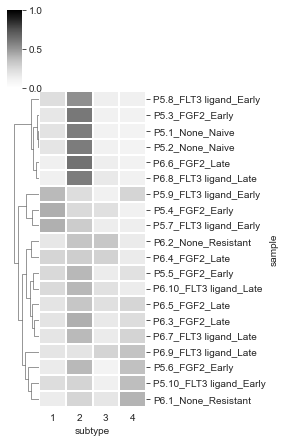

In [181]:
g = sns.clustermap(
    cl_preds_prob.set_index('sample')[subtypes],
    vmax=1, vmin=0,
    col_cluster=False,
    cmap='Greys',
    linewidths=0.01,
    figsize=(4,6)
)

g.ax_heatmap.set_xticklabels([1,2,3,4])
g.ax_heatmap.set_xlabel("subtype")
# g.set_ylabel(cell_line_labels)

In [182]:
cl_preds_prob

,index,1,2,3,4,sample,stage
0,P5.10_FLT3 ligand_Early,0.227610,0.277183,0.121503,0.373704,P5.10_FLT3 ligand_Early,1_Early
1,P5.1_None_Naive,0.196486,0.586671,0.112680,0.104163,P5.1_None_Naive,0_Naive
2,P5.2_None_Naive,0.185536,0.592901,0.116873,0.104689,P5.2_None_Naive,0_Naive
3,P5.3_FGF2_Early,0.171931,0.607391,0.114794,0.105883,P5.3_FGF2_Early,1_Early
4,P5.4_FGF2_Early,0.424642,0.244517,0.212690,0.118151,P5.4_FGF2_Early,1_Early
5,P5.5_FGF2_Early,0.252542,0.392907,0.150306,0.204246,P5.5_FGF2_Early,1_Early
6,P5.6_FGF2_Early,0.153326,0.389593,0.098419,0.358661,P5.6_FGF2_Early,1_Early
7,P5.7_FLT3 ligand_Early,0.414201,0.309113,0.141690,0.134997,P5.7_FLT3 ligand_Early,1_Early
8,P5.8_FLT3 ligand_Early,0.223734,0.525306,0.129255,0.121704,P5.8_FLT3 ligand_Early,1_Early
9,P5.9_FLT3 ligand_Early,0.386104,0.228563,0.118731,0.266601,P5.9_FLT3 ligand_Early,1_Early


In [183]:
cl_melt = cl_preds_prob.melt(
    id_vars=['index', 'sample', 'stage'], 
    value_vars=subtypes,
    var_name='subtype'
)

In [184]:
cl_melt

,index,sample,stage,subtype,value
0,P5.10_FLT3 ligand_Early,P5.10_FLT3 ligand_Early,1_Early,1,0.227610
1,P5.1_None_Naive,P5.1_None_Naive,0_Naive,1,0.196486
2,P5.2_None_Naive,P5.2_None_Naive,0_Naive,1,0.185536
3,P5.3_FGF2_Early,P5.3_FGF2_Early,1_Early,1,0.171931
4,P5.4_FGF2_Early,P5.4_FGF2_Early,1_Early,1,0.424642
...,...,...,...,...,...
75,P6.5_FGF2_Late,P6.5_FGF2_Late,2_Late,4,0.262241
76,P6.6_FGF2_Late,P6.6_FGF2_Late,2_Late,4,0.109876
77,P6.7_FLT3 ligand_Late,P6.7_FLT3 ligand_Late,2_Late,4,0.276897
78,P6.8_FLT3 ligand_Late,P6.8_FLT3 ligand_Late,2_Late,4,0.120247


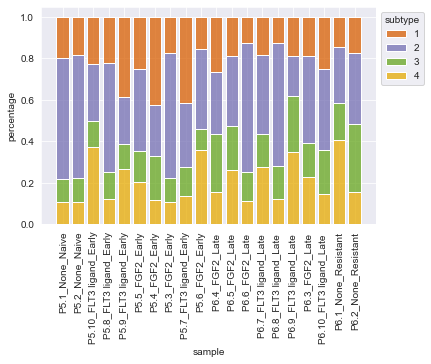

In [185]:
cl_melt.sort_values('stage', inplace=True)
# order = cl_melt['stage'].values

# One liner to create a stacked bar chart.
ax = sns.histplot(
    cl_melt, 
    x='sample', 
    hue='subtype',
    weights='value',
    multiple='stack',
    hue_order=subtypes,
    
    palette=cluster_colors,

    shrink=0.8
)

ax.set_ylabel('percentage')
# ax.set_xticklabels( rotation=90)
plt.setp( ax.xaxis.get_majorticklabels(), rotation=90 )
# Fix the legend so it's not on top of the bars.
legend = ax.get_legend()
legend.set_bbox_to_anchor((1, 1))
plt.savefig('cell_line_projection_new.png', bbox_inches='tight', dpi=300)
plt.savefig('cell_line_projection_new.pdf', bbox_inches='tight', dpi=300)

In [186]:
outside_nmf

label,sample_id,A2M_prot,AAAS-S495s,AAAS-S541s,AAAS_prot,AACS_prot,AAGAB_prot,AAK1-S18s,AAK1-S20s,AAK1-S21s,...,ZYX-Y172y,ZYX_prot,ZZEF1-S1464s,ZZEF1-S1518s,ZZEF1-S2526s,ZZEF1-T1512tS1518s,ZZEF1_prot,ZZZ3-S314s,ZZZ3_prot,hCG_2039718-S157s
0,11-00261,-0.49700,1.1900,NaN,-0.270000,-0.47100,-0.3200,-0.58600,-0.3920,-0.61800,...,-0.3650,-0.07460,-1.0700,-0.072700,-8.070000e-01,-0.15400,-0.19300,1.0900,0.64900,0.4770
1,11-00376,-0.26700,NaN,NaN,-0.108000,0.90600,0.1720,0.08740,1.1400,0.56800,...,-0.3040,0.36800,1.4900,0.616000,3.190000e-01,1.39000,0.43900,NaN,-0.02000,-0.2260
2,11-00378,1.86000,NaN,-0.25000,0.066900,1.16000,0.0781,0.08120,0.0695,-0.18200,...,0.3670,0.88900,0.8970,0.366000,-4.400000e-01,NaN,0.47100,0.4290,-0.03320,0.5010
3,11-00382,-0.75200,-2.7700,NaN,0.023200,0.32600,-0.1140,0.74000,0.5100,-0.08290,...,NaN,0.11300,0.7470,2.030000,-1.160000e-02,NaN,0.09790,NaN,-0.03490,1.0500
4,11-00388,-0.19600,0.4270,-0.07150,0.041300,0.42500,0.1040,NaN,1.5700,1.51000,...,NaN,-0.11600,0.0619,3.210000,2.210000e-01,NaN,0.35300,0.1410,-0.03330,-1.2400
5,11-00416,-0.19700,0.8200,-1.68000,0.371000,-0.33400,0.5300,0.42300,NaN,-2.42000,...,NaN,0.00956,0.9590,0.679000,8.290000e-02,NaN,0.06730,-2.3600,0.34400,1.1400
6,11-00465,-0.51700,0.7230,1.00000,-0.022600,-0.20400,-0.2360,0.05930,-0.2280,-1.12000,...,NaN,-0.26900,0.6700,-0.038200,-8.790000e-01,-1.12000,-0.27200,1.0200,-0.44800,0.1800
7,11-00466,-0.14700,0.5200,1.55000,1.170000,-0.05460,0.0554,-0.13200,NaN,1.08000,...,NaN,-0.29800,0.4880,0.630000,-1.100000e+00,NaN,-0.00525,0.7020,0.54400,NaN
8,11-00475,-0.31200,0.4980,-0.04330,-0.169000,-0.01230,0.8530,-1.46000,-1.2800,-0.56000,...,-0.2920,-1.41000,-0.2410,-0.053600,7.170000e-01,0.06080,-0.38200,1.0200,0.43500,-0.8110
9,11-00503,-0.50300,-0.9060,1.68000,0.114000,0.01620,-0.1340,-0.31500,-0.3810,0.07300,...,1.2400,-0.33500,-0.0521,-0.714000,-1.140000e+00,-0.52400,-0.11300,0.7930,0.24200,0.4400


# 51 patients that don't have RNAseq

In [187]:
outside_nmf_features = outside_nmf[fets]
outside_nmf_scaled = StandardScaler().fit_transform(outside_nmf_features)

In [188]:
outside_nmf_preds_prob= lgb_model_slim.predict_proba(
    outside_nmf_scaled, num_iteration=lgb_model_slim.best_iteration_
)

In [189]:
outside_nmf_preds_prob = pd.DataFrame(outside_nmf_preds_prob, index=outside_nmf.sample_id.values)

In [190]:
outside_nmf_preds_prob

,0,1,2,3
11-00261,0.105542,0.683235,0.111235,0.099987
11-00376,0.132622,0.165544,0.135245,0.566589
11-00378,0.147779,0.145211,0.256375,0.450635
11-00382,0.452245,0.288131,0.134900,0.124724
11-00388,0.412658,0.256703,0.185304,0.145335
11-00416,0.208210,0.379813,0.202422,0.209554
11-00465,0.160933,0.476194,0.140430,0.222442
11-00466,0.201890,0.472072,0.182313,0.143724
11-00475,0.107523,0.669263,0.124548,0.098666
11-00503,0.161465,0.248177,0.164494,0.425865


Text(0.5, 88.0, 'subtype')

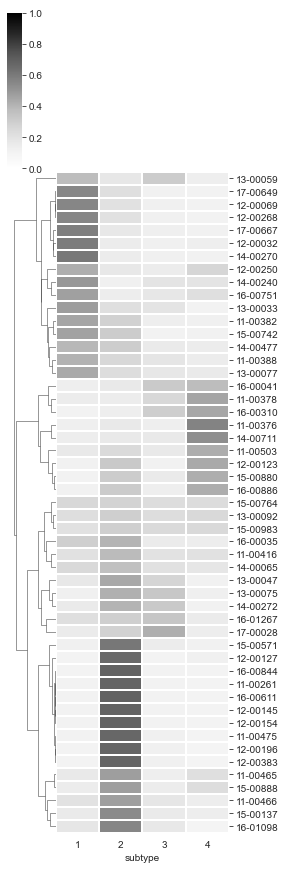

In [191]:
g = sns.clustermap(
    outside_nmf_preds_prob,
    vmax=1, vmin=0,
    col_cluster=False,
    cmap='Greys', linewidths=0.01,
    yticklabels=True,
    figsize=(4,12)
)

g.ax_heatmap.set_xticklabels([1,2,3,4])
g.ax_heatmap.set_xlabel("subtype")
# g.set_ylabel(cell_line_labels)

## Difference between 21 feature model and all feature model

In [192]:
outside_nmf

label,sample_id,A2M_prot,AAAS-S495s,AAAS-S541s,AAAS_prot,AACS_prot,AAGAB_prot,AAK1-S18s,AAK1-S20s,AAK1-S21s,...,ZYX-Y172y,ZYX_prot,ZZEF1-S1464s,ZZEF1-S1518s,ZZEF1-S2526s,ZZEF1-T1512tS1518s,ZZEF1_prot,ZZZ3-S314s,ZZZ3_prot,hCG_2039718-S157s
0,11-00261,-0.49700,1.1900,NaN,-0.270000,-0.47100,-0.3200,-0.58600,-0.3920,-0.61800,...,-0.3650,-0.07460,-1.0700,-0.072700,-8.070000e-01,-0.15400,-0.19300,1.0900,0.64900,0.4770
1,11-00376,-0.26700,NaN,NaN,-0.108000,0.90600,0.1720,0.08740,1.1400,0.56800,...,-0.3040,0.36800,1.4900,0.616000,3.190000e-01,1.39000,0.43900,NaN,-0.02000,-0.2260
2,11-00378,1.86000,NaN,-0.25000,0.066900,1.16000,0.0781,0.08120,0.0695,-0.18200,...,0.3670,0.88900,0.8970,0.366000,-4.400000e-01,NaN,0.47100,0.4290,-0.03320,0.5010
3,11-00382,-0.75200,-2.7700,NaN,0.023200,0.32600,-0.1140,0.74000,0.5100,-0.08290,...,NaN,0.11300,0.7470,2.030000,-1.160000e-02,NaN,0.09790,NaN,-0.03490,1.0500
4,11-00388,-0.19600,0.4270,-0.07150,0.041300,0.42500,0.1040,NaN,1.5700,1.51000,...,NaN,-0.11600,0.0619,3.210000,2.210000e-01,NaN,0.35300,0.1410,-0.03330,-1.2400
5,11-00416,-0.19700,0.8200,-1.68000,0.371000,-0.33400,0.5300,0.42300,NaN,-2.42000,...,NaN,0.00956,0.9590,0.679000,8.290000e-02,NaN,0.06730,-2.3600,0.34400,1.1400
6,11-00465,-0.51700,0.7230,1.00000,-0.022600,-0.20400,-0.2360,0.05930,-0.2280,-1.12000,...,NaN,-0.26900,0.6700,-0.038200,-8.790000e-01,-1.12000,-0.27200,1.0200,-0.44800,0.1800
7,11-00466,-0.14700,0.5200,1.55000,1.170000,-0.05460,0.0554,-0.13200,NaN,1.08000,...,NaN,-0.29800,0.4880,0.630000,-1.100000e+00,NaN,-0.00525,0.7020,0.54400,NaN
8,11-00475,-0.31200,0.4980,-0.04330,-0.169000,-0.01230,0.8530,-1.46000,-1.2800,-0.56000,...,-0.2920,-1.41000,-0.2410,-0.053600,7.170000e-01,0.06080,-0.38200,1.0200,0.43500,-0.8110
9,11-00503,-0.50300,-0.9060,1.68000,0.114000,0.01620,-0.1340,-0.31500,-0.3810,0.07300,...,1.2400,-0.33500,-0.0521,-0.714000,-1.140000e+00,-0.52400,-0.11300,0.7930,0.24200,0.4400


In [193]:
outside_nmf_features = outside_nmf[features.columns]
outside_nmf_scaled = StandardScaler().fit_transform(outside_nmf_features)

outside_nmf_preds_prob = lgb_model.predict_proba(outside_nmf_scaled, num_iteration=lgb_model.best_iteration_)
outside_nmf_preds_prob = pd.DataFrame(outside_nmf_preds_prob, index=outside_nmf.sample_id.values)

In [194]:
outside_nmf_features = outside_nmf[top_feats.columns]
outside_nmf_scaled = StandardScaler().fit_transform(outside_nmf_features)

outside_nmf_preds_prob_slim = lgb_model_slim.predict_proba(outside_nmf_scaled, num_iteration=lgb_model_slim.best_iteration_)
outside_nmf_preds_prob_slim = pd.DataFrame(outside_nmf_preds_prob_slim, index=outside_nmf.sample_id.values)

In [195]:
outside_nmf_preds_prob_slim

,0,1,2,3
11-00261,0.105542,0.683235,0.111235,0.099987
11-00376,0.132622,0.165544,0.135245,0.566589
11-00378,0.147779,0.145211,0.256375,0.450635
11-00382,0.452245,0.288131,0.134900,0.124724
11-00388,0.412658,0.256703,0.185304,0.145335
11-00416,0.208210,0.379813,0.202422,0.209554
11-00465,0.160933,0.476194,0.140430,0.222442
11-00466,0.201890,0.472072,0.182313,0.143724
11-00475,0.107523,0.669263,0.124548,0.098666
11-00503,0.161465,0.248177,0.164494,0.425865


In [196]:
outside_nmf_preds_prob

,0,1,2,3
11-00261,0.108942,0.663659,0.119394,0.108005
11-00376,0.124206,0.154841,0.126540,0.594414
11-00378,0.167793,0.133246,0.238364,0.460597
11-00382,0.436616,0.273695,0.144406,0.145283
11-00388,0.385735,0.264341,0.204224,0.145699
11-00416,0.198873,0.338176,0.194810,0.268142
11-00465,0.171942,0.418795,0.154932,0.254331
11-00466,0.179354,0.471950,0.199826,0.148870
11-00475,0.103924,0.675023,0.124388,0.096665
11-00503,0.178476,0.252691,0.188618,0.380215


Text(0.5, 88.0, 'subtype')

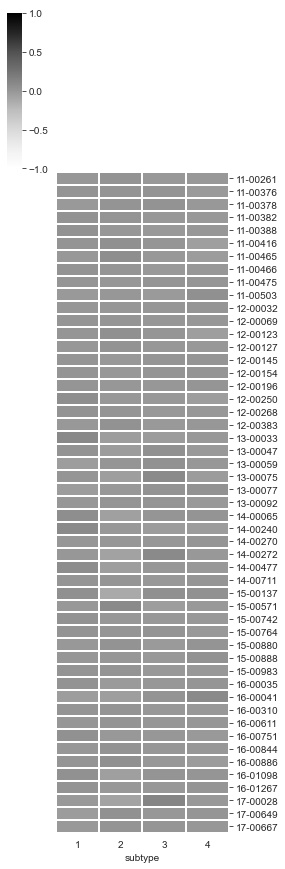

In [197]:
g = sns.clustermap(
    outside_nmf_preds_prob_slim- outside_nmf_preds_prob,
    vmax=1,
    vmin=-1,
    col_cluster=False,
    row_cluster=False,
    cmap='Greys',
    linewidths=0.01,
    yticklabels=True,
    figsize=(4,12)
)

g.ax_heatmap.set_xticklabels([1,2,3,4])
g.ax_heatmap.set_xlabel("subtype")

In [198]:
outside_nmf_preds_prob_slim- outside_nmf_preds_prob

,0,1,2,3
11-00261,-0.003400,0.019577,-0.008159,-0.008018
11-00376,0.008416,0.010704,0.008705,-0.027825
11-00378,-0.020014,0.011965,0.018011,-0.009962
11-00382,0.015630,0.014436,-0.009506,-0.020559
11-00388,0.026923,-0.007638,-0.018921,-0.000364
11-00416,0.009338,0.041638,0.007613,-0.058588
11-00465,-0.011009,0.057399,-0.014501,-0.031889
11-00466,0.022536,0.000122,-0.017513,-0.005146
11-00475,0.003599,-0.005760,0.000161,0.002001
11-00503,-0.017011,-0.004514,-0.024124,0.045649


In [199]:
outside_nmf_preds_prob_slim.rename(
    {
        0:'0 slim',
        1:'1 slim',
        2:'2 slim',
        3:'3 slim',
    },
    axis=1,
    inplace=True
)

outside_nmf_preds_prob.rename(
    {
        0:'0 all',
        1:'1 all',
        2:'2 all',
        3:'3 all',
    },
    axis=1,
    inplace=True
)

In [200]:
merged_outside = pd.concat([outside_nmf_preds_prob, outside_nmf_preds_prob_slim], axis=1)

Text(0.5, 70.625, 'subtype')

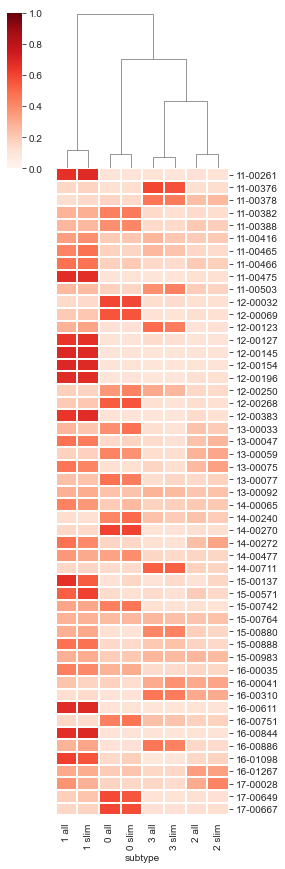

In [201]:
g = sns.clustermap(
    merged_outside,
    vmax=1, vmin=0,
    col_cluster=True,
    row_cluster=False,
    cmap='Reds', linewidths=0.01,
    yticklabels=True,
    figsize=(4,12)
)





# g.ax_heatmap.set_xticklabels([1,2,3,4])
g.ax_heatmap.set_xlabel("subtype")
# g.set_ylabel(cell_line_labels)

# Apply classifier to CPTAC4 data

In [202]:
prot_id = "syn51082494"
phospho_id = "syn51425620"

In [203]:
from pybeataml.load_data_from_synpase import load_file

In [204]:
meta_info = load_file("syn51080395", delimiter=',')
meta_info['Participant'] = meta_info['Participant'].str.replace('.', '-')
mapper = meta_info[['Participant', 'Label']].set_index("Label").to_dict()['Participant']

In [205]:
protein_ratio = load_file('syn51082495')
protein_ratio['label'] = protein_ratio.Gene_name + '_prot'
protein_ratio.drop(['Gene_name', 'Index'], axis=1, inplace=True)
protein_ratio.set_index('label', inplace=True)
protein_ratio.head()

,C3L.00452.58.BMA,C3L.00453.59.BMA,C3L.00455.59.BMA,C3L.00458.58.PB,C3L.00459.59.BMA,C3L.00540.54.PB,C3L.00614.54.PB,C3L.00810.58.PB,C3L.01188.33.BMA,C3L.01202.58.BMA,...,C3L.06356.33.BMA,C3L.06357.33.BMA,C3L.06361.33.BMA,C3L.06364.33.BMA,C3L.06367.33.BMA,C3L.06368.33.BMA,C3L.06369.35.BMA,C3L.06374.33.BMA,C3L.06386.34.PB,C3L.07490.33.BMA
label,,,,,,,,,,,,,,,,,,,,,
TSPAN6_prot,NaN,0.271941,NaN,NaN,-0.107229,NaN,NaN,-0.831140,-0.093276,NaN,...,NaN,NaN,NaN,-0.061550,NaN,NaN,NaN,NaN,NaN,NaN
DPM1_prot,-0.179340,-0.144565,-0.344382,-0.411983,-0.112446,-0.755765,0.010316,-0.034579,0.154493,-0.090741,...,0.083094,0.923848,-0.165401,0.187192,-0.161234,-1.127226,0.045474,-0.384363,-0.155650,0.201466
SCYL3_prot,-0.307761,0.309033,0.282500,0.285536,0.249673,0.154905,0.604595,-0.016277,0.177718,0.331711,...,-0.959693,0.314785,-0.275194,0.776705,0.529525,0.275046,-0.517200,-0.254624,-0.386802,-0.181541
C1orf112_prot,-0.523518,-0.181236,NaN,-0.932106,-0.022739,NaN,0.225512,0.288812,0.715553,-0.264997,...,NaN,-0.483611,-0.049699,-0.108648,NaN,0.103923,NaN,NaN,-0.519092,-0.231802
FGR_prot,-0.557287,-0.704280,0.854767,1.827059,0.386120,-0.678610,1.431006,-1.720226,-0.271122,1.189860,...,-0.355551,-1.741113,0.616729,-1.696797,0.124619,-0.589173,0.746557,0.301514,-1.029509,1.191592


In [206]:
protein_ratio.rename(columns=mapper, inplace=True)

In [207]:
phospho_ratio = load_file(phospho_id)
phospho_ratio.drop_duplicates(inplace=True)
phospho_ratio['label'] = phospho_ratio.Gene_site.str.replace('_', '-')
phospho_ratio.drop(['Gene_site', 'SequenceWindow'], axis=1, inplace=True)
phospho_ratio.set_index('label', inplace=True)
phospho_ratio.head()

,C3L-00452,C3L-00453,C3L-00455,C3L-00458,C3L-00459,C3L-00540,C3L-00614,C3L-00810,C3L-01188,C3L-01202,...,C3L-06356,C3L-06357,C3L-06361,C3L-06364,C3L-06367,C3L-06368,C3L-06369,C3L-06374,C3L-06386,C3L-07490
label,,,,,,,,,,,,,,,,,,,,,
AAAS-S495,-1.373287,0.385456,0.062687,-0.833179,0.13372,0.509871,0.346933,0.681531,0.196514,0.408425,...,-2.919832,-0.588223,-2.369095,-0.257864,0.162086,-2.296525,-1.006701,-1.992665,-2.030601,-1.911032
AAAS-S541,NaN,NaN,-0.016087,NaN,NaN,0.106162,NaN,NaN,NaN,0.698115,...,0.334476,NaN,NaN,NaN,-0.601543,0.579055,-1.045057,NaN,NaN,NaN
AAAS-Y485,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.224968,NaN,NaN
AAGAB-S310,0.080380,NaN,NaN,-1.488993,NaN,NaN,-0.215890,NaN,NaN,NaN,...,NaN,0.695748,NaN,NaN,NaN,NaN,NaN,0.466276,-2.031322,0.074273
AAGAB-S311,NaN,NaN,NaN,NaN,NaN,NaN,-0.591028,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.134636


In [208]:
gw_data = pd.concat([protein_ratio, phospho_ratio], ignore_index=False).T
gw_data.head()

label,TSPAN6_prot,DPM1_prot,SCYL3_prot,C1orf112_prot,FGR_prot,CFH_prot,FUCA2_prot,GCLC_prot,NFYA_prot,NIPAL3_prot,...,ZZZ3-S131,ZZZ3-S135,ZZZ3-S271,ZZZ3-S381,ZZZ3-S391,ZZZ3-S606,ZZZ3-S777,ZZZ3-S89,ZZZ3-T301,ZZZ3-Y399
C3L-00452,NaN,-0.179340,-0.307761,-0.523518,-0.557287,-0.302040,0.479570,-0.419037,-0.452715,NaN,...,0.074619,NaN,0.090354,-0.282941,0.240661,NaN,NaN,0.155247,NaN,NaN
C3L-00453,0.271941,-0.144565,0.309033,-0.181236,-0.704280,-0.780800,-0.531539,1.252892,-0.085555,0.283102,...,NaN,-0.090587,NaN,-0.345839,-0.126389,-0.635434,NaN,0.523892,NaN,NaN
C3L-00455,NaN,-0.344382,0.282500,NaN,0.854767,-0.695206,0.164759,-0.509850,0.976467,NaN,...,NaN,-0.176453,NaN,-0.345765,-0.059731,NaN,NaN,0.316475,NaN,NaN
C3L-00458,NaN,-0.411983,0.285536,-0.932106,1.827059,0.593013,0.182995,-0.008618,0.460850,NaN,...,NaN,NaN,NaN,NaN,0.167864,0.188185,NaN,0.518141,-3.462615,NaN
C3L-00459,-0.107229,-0.112446,0.249673,-0.022739,0.386120,0.493919,0.334185,0.515712,-0.546401,-0.112191,...,NaN,-0.258914,NaN,-0.355667,0.164655,-0.399955,NaN,-0.814230,NaN,NaN


In [209]:
beat_feat = set(top_feats.columns)
in_gw = set(gw_data.columns)
in_both = beat_feat.intersection(in_gw)
add_nan = beat_feat.difference(in_gw)
print(len(in_both), len(add_nan))

19 2


In [210]:
# features missing in wg data
add_nan

{'ARGLU1-S77s', 'CASP3-S26s'}

In [211]:
to_stack = features[list(add_nan)].copy()
to_stack.iloc[:] = np.nan

In [212]:
to_stack.index = gw_data.index[:159]

In [213]:
gw_data = pd.concat([gw_data, to_stack], axis=1)

In [214]:

wg_features = gw_data[top_feats.columns].copy()
wg_scaled = StandardScaler().fit_transform(wg_features)


wg_preds_max = lgb_model_slim.predict(wg_scaled, num_iteration=lgb_model_slim.best_iteration_)
wg_preds_prob = lgb_model_slim.predict_proba(wg_scaled, num_iteration=lgb_model_slim.best_iteration_)

[WARNING] C:\Users\pino216\Miniconda3\envs\beatAML_env_37\lib\site-packages\sklearn\utils\extmath.py:985: RuntimeWarning:

invalid value encountered in true_divide


[WARNING] C:\Users\pino216\Miniconda3\envs\beatAML_env_37\lib\site-packages\sklearn\utils\extmath.py:990: RuntimeWarning:

invalid value encountered in true_divide


[WARNING] C:\Users\pino216\Miniconda3\envs\beatAML_env_37\lib\site-packages\sklearn\utils\extmath.py:1020: RuntimeWarning:

invalid value encountered in true_divide




In [215]:
gw_data['predicted_clusters'] = wg_preds_max

In [216]:
gw_data['predicted_clusters'].to_csv("cptac4_predicted_clusters_lightgbm_classifer.csv")

Text(0.5, 88.0, 'subtype')

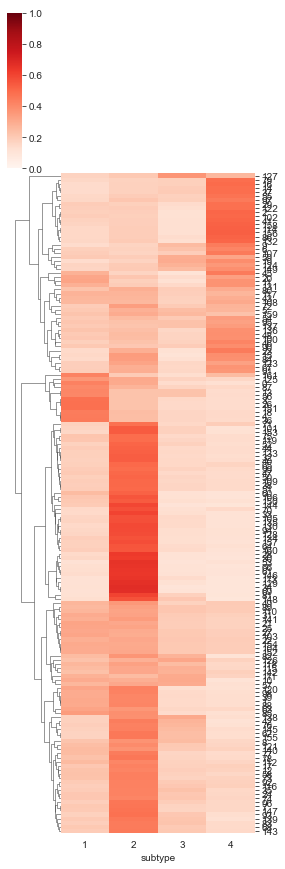

In [217]:
g = sns.clustermap(
    wg_preds_prob,
    vmax=1, vmin=0,
    col_cluster=False,
    cmap='Reds', linewidths=0.001,
    yticklabels=True,
    figsize=(4,12)
)

g.ax_heatmap.set_xticklabels([1,2,3,4])
g.ax_heatmap.set_xlabel("subtype")
# g.set_ylabel(cell_line_labels)

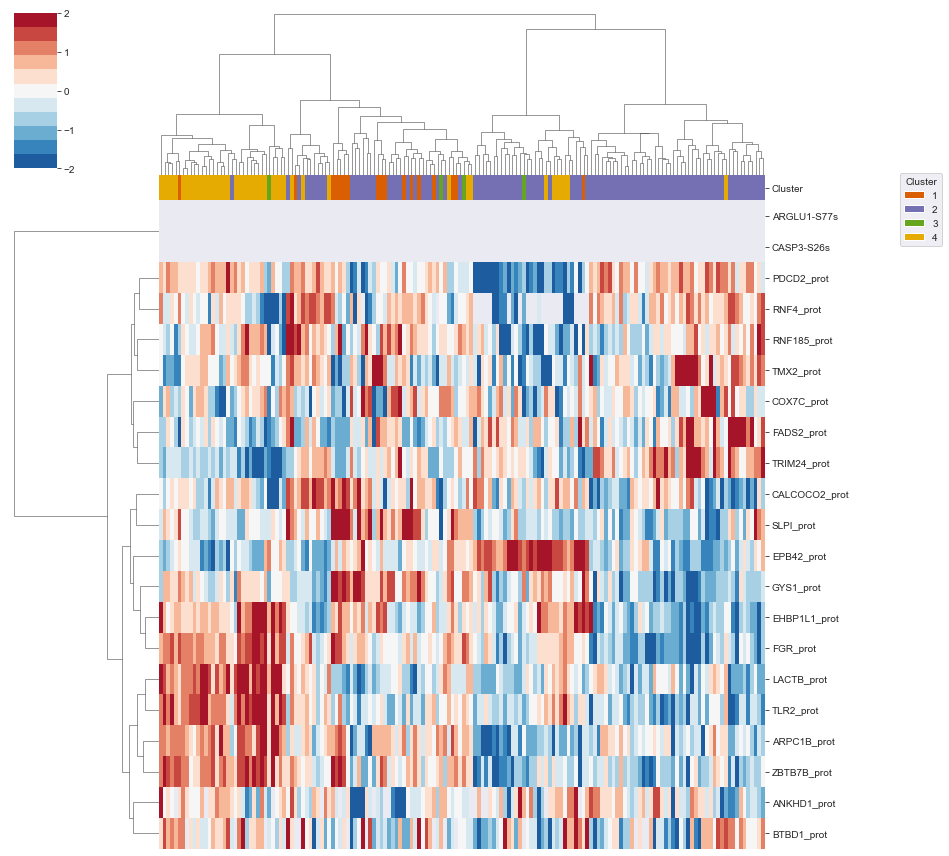

In [218]:
prot = gw_data[fets].T

# create cluster labels for top
node_labels = gw_data['predicted_clusters']
node_lut = dict(zip(sorted(node_labels.unique()), cluster_colors))
node_colors = pd.Series(node_labels, index=gw_data.index.values, name='Cluster').map(node_lut)
handles = [Patch(facecolor=node_lut[name]) for name in node_lut]


in_all_nodes = set(prot.columns).intersection(node_colors.index)
# prot = prot[in_all_nodes]
# prot = prot[rna_patients]
cmap = sns.color_palette("RdBu_r", 11)
vmax = 2
sns.clustermap(
    prot.fillna(0.01),
    mask=prot.isnull(),
    figsize=(12, 12),
    z_score=0,
    row_cluster=True,
    col_cluster=True,
    method='ward',
    metric='euclidean',
    col_colors= node_colors,
    vmax=vmax,
    vmin=-1*vmax,
    yticklabels=True,
    xticklabels=False,
    cmap=cmap
#     linewidths=0.001

)

plt.legend(
    handles, node_lut, title='Cluster',
    bbox_to_anchor=(1.1, .8),
    bbox_transform=plt.gcf().transFigure,
    loc='upper right'
)

In [219]:
from magine.enrichment.enrichr import Enrichr
e = Enrichr()

In [220]:
for_enrich = [i.strip('_prot') for i in fets]
for_enrich = [i.split('-')[0] for i in for_enrich]
for_enrich

['ANKHD1',
 'ARGLU1',
 'ARPC1B',
 'BTBD1',
 'CALCOCO2',
 'CASP3',
 'COX7C',
 'EHBP1L1',
 'EPB42',
 'FADS2',
 'FGR',
 'GYS1',
 'LACTB',
 'PDCD2',
 'RNF185',
 'RNF4',
 'SLPI',
 'TLR2',
 'TMX2',
 'TRIM24',
 'ZBTB7B']

In [221]:
enr = e.run(for_enrich, gene_set_lib="Reactome_2022")
enr

63302730


,term_name,rank,p_value,z_score,combined_score,adj_p_value,genes,n_genes,db,significant
0,disease r-hsa-1643685,1,0.001433,5.277617,34.558178,0.077709,"ARPC1B,FGR,GYS1,RNF185,SLPI,TLR2,TRIM24",7,Reactome_2022,False
1,fcgr3a-mediated phagocytosis r-hsa-9664422,2,0.001792,36.154265,228.663428,0.077709,"ARPC1B,FGR",2,Reactome_2022,False
2,immune system r-hsa-168256,3,0.002758,4.659866,27.461557,0.077709,"ARPC1B,BTBD1,CASP3,FGR,RNF4,SLPI,TLR2",7,Reactome_2022,False
3,fcgamma receptor (fcgr) dependent phagocytosis...,4,0.003723,24.636533,137.800452,0.077709,"ARPC1B,FGR",2,Reactome_2022,False
4,synthesis of gdp-mannose r-hsa-446205,5,0.005239,249.687500,1311.244059,0.077709,SLPI,1,Reactome_2022,False
...,...,...,...,...,...,...,...,...,...,...
121,developmental biology r-hsa-1266738,122,0.686072,0.881856,0.332259,0.708566,ARPC1B,1,Reactome_2022,False
122,generic transcription pathway r-hsa-212436,123,0.724420,0.790160,0.254735,0.742089,COX7C,1,Reactome_2022,False
123,signal transduction r-hsa-162582,124,0.750569,0.748595,0.214789,0.762675,"ARPC1B,CASP3",2,Reactome_2022,False
124,rna polymerase ii transcription r-hsa-73857,125,0.759635,0.711976,0.195734,0.765712,COX7C,1,Reactome_2022,False


In [222]:
enr['sample_id'] = 'top feats'

In [223]:
enr

,term_name,rank,p_value,z_score,combined_score,adj_p_value,genes,n_genes,db,significant,sample_id
0,disease r-hsa-1643685,1,0.001433,5.277617,34.558178,0.077709,"ARPC1B,FGR,GYS1,RNF185,SLPI,TLR2,TRIM24",7,Reactome_2022,False,top feats
1,fcgr3a-mediated phagocytosis r-hsa-9664422,2,0.001792,36.154265,228.663428,0.077709,"ARPC1B,FGR",2,Reactome_2022,False,top feats
2,immune system r-hsa-168256,3,0.002758,4.659866,27.461557,0.077709,"ARPC1B,BTBD1,CASP3,FGR,RNF4,SLPI,TLR2",7,Reactome_2022,False,top feats
3,fcgamma receptor (fcgr) dependent phagocytosis...,4,0.003723,24.636533,137.800452,0.077709,"ARPC1B,FGR",2,Reactome_2022,False,top feats
4,synthesis of gdp-mannose r-hsa-446205,5,0.005239,249.687500,1311.244059,0.077709,SLPI,1,Reactome_2022,False,top feats
...,...,...,...,...,...,...,...,...,...,...,...
121,developmental biology r-hsa-1266738,122,0.686072,0.881856,0.332259,0.708566,ARPC1B,1,Reactome_2022,False,top feats
122,generic transcription pathway r-hsa-212436,123,0.724420,0.790160,0.254735,0.742089,COX7C,1,Reactome_2022,False,top feats
123,signal transduction r-hsa-162582,124,0.750569,0.748595,0.214789,0.762675,"ARPC1B,CASP3",2,Reactome_2022,False,top feats
124,rna polymerase ii transcription r-hsa-73857,125,0.759635,0.711976,0.195734,0.765712,COX7C,1,Reactome_2022,False,top feats


Number of rows went from 126 to 12


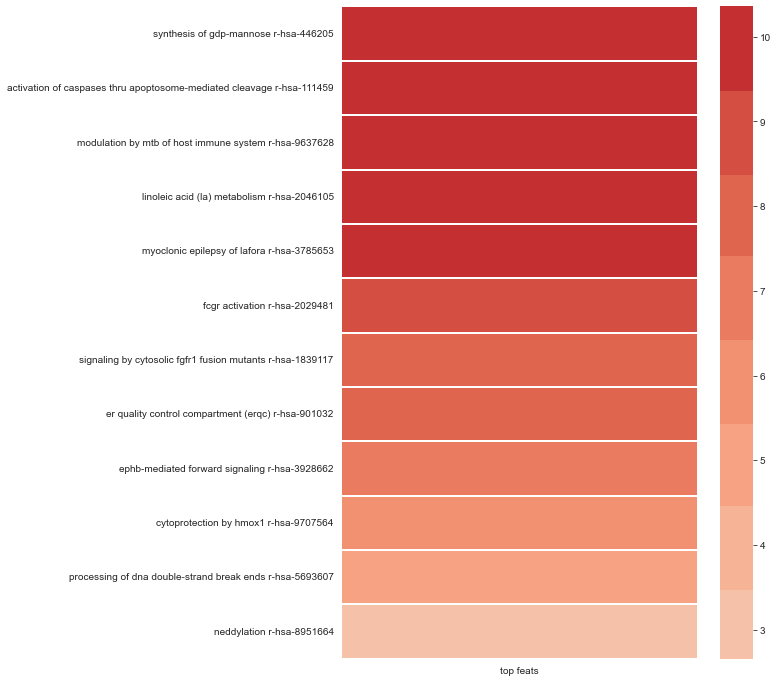

In [224]:
enr.remove_redundant().heatmap(linewidths=0.01);